## 머신러닝을 이용한여 언어 감지 서비스 구축

### 1. 연구 목표 설정

- 유사서비스 : 파파고, 구글 번역
- 개요
    - 번역 서비스중 언어 감지 파트는 머신러닝의 지도학습법 중 분류를 사용하겟다
    - 알파벳을 사용하는 영어권에서는 알파벳 언어별로 알파벳의 사용 빈도가 다르다
- 조건
    - 비 영어권은 개별 방법론(완성형(utf-8), 조합형(euc-kr) 코드를 이용하여 판단) 배제
    - 임시값(100byte) 이내 문자열을 배제, 임시값의 임계값은 변경될수 있다
    - 번역서비스는 딥러닝의 RNN을 활용하여 처리하는데 여기서는 배제,단, 파파고 API를 활용하여 유사하게 구현
    - 서비스가 오픈하고 데이터가 축적되면 모델을 갱신(언어는 진화하니까) 모델을 다시 학습하고 교체를 진행하는데 원활하게 수행되겠금 처리(전략). 일단 여기서는 데이터 축적

|No|단계|내용|
|:---:|:---|:---|
|1|연구 목표 설정|- 웹서비스<br>- 사용자가 입력한 텍스트를 예측하여 어떤 언어인지 판독한다(영어권,알파벳 사용국가)<br>- 머신러닝의 지도학습-분류를 사용하겟다<br>- 파이프라인구축, 하이터파라미터튜닝을 이용한 최적화 부분은 제외<br>- 정량적인 목표치는 생략(평가배제)<br>- 임시값(100byte) 이내 문자열을 배제<br>- 논문을 통한 주장의 근거를 체크|
|2|데이터 획득/수집|- 실전:다양한 텍스트를 수집, 위키피디아, 법률, 소설등등<br>- 구현:제공데이터를 사용(법령/대본/소설등)|
|3|데이터 준비/통찰/전처리|- 알파벳을 제외한 모든 문자 제거(전처리,정규식)<br>- 텍스트를 알파벳의 출현 빈도로 계산한다(문자계산, 데이터의 수치화)<br>- 데이터는 훈련 데이터(훈련(50), 검증(25))와 테스트 데이터(25)로 나눈다 (훈련:테스트=75:25) 황금비율, 단 바뀔수 있다|
|4|데이터 탐색/통찰/시각화|- 논문의 주장을 증명<br>- 영어권 언어별로 알파벳 출현 빈도가 다르다는 명제를 증명/확인<br>- EDA 분석(시각화)를 이용하여 확인, 선형차트, 바차트 등을 활용|
|5|데이터 모델링 및 모델 구축|- 알고리즘 선정<br>- 학습데이터/테스트데이터 준비<br>- 학습<br>- 예측<br>- 성능평가(학습법,하위 카테고리 까지 검토 평가)<br>- 파이프라인구축을 통하여 알고리즘 체인을 적용, 최적의 알고리즘 조합을 찾는다<br>- 연구 목표에 도착할때까지 반복<br>- 모델 덤프(학습된 알고리즘을 파일로 덤프)|
|6|시스템 통합|- 웹서비스 구축(flask 간단하게 구성)<br>- 서비스 구축<br>- 모델의 업그레이드를 위한 시스템 추가<br>- 선순환구조를 위한 번역 요청 데이터의 로그 처리->배치학습, 온라인 학습등으로 연결되어 완성|

### 2. 데이터 획득

- 실전:다양한 텍스트를 수집, 위키피디아, 법률, 소설등등
    - 라이브러리 : request, BS4 <- Lv3
    - 사이트 : https://언어코드.wikipedia.org/wiki/검색어
        - 예) https://en.wikipedia.org/wiki/Bong_Joon-ho
- 구현:제공데이터를 사용(법령/대본/소설등)

In [1]:
# 모듈 가져오기
import urllib.request as req
from bs4 import BeautifulSoup

In [2]:
# 데이터 획득 사이트 규격화
target_site = 'https://{na_code}.wikipedia.org/wiki/{keyword}'.format( na_code='en',
                                                         keyword='Bong_Joon-ho' )
target_site

'https://en.wikipedia.org/wiki/Bong_Joon-ho'

In [3]:
# 요청 및 SOUP 생성(DOM 트리)
# html5lib 파서 사용 이유: 대량의 html을 파싱하기 위해 안전성 고려
soup = BeautifulSoup( req.urlopen(target_site), 'html5lib' )

In [4]:
# 데이터 추출
# css selector : #mw-content-text p
tmp = soup.select('#mw-content-text  p')
len(tmp), type(tmp)

(22, bs4.element.ResultSet)

In [5]:
# p 밑에 있는 모든 텍스트를 리스트에 모아 둔다 => 맴버수가 => 22개
# 리스트 생성
texts = list() 
for p in tmp:
    # 맴버 추가
    texts.append(p.text )
    #print( type(p.text), p.text )
len(texts), texts[:2]

(22,
 ['\n',
  'Bong Joon-ho (Korean:\xa0봉준호, Korean pronunciation:\xa0[poːŋ tɕuːnho → poːŋdʑunɦo]; born September 14, 1969) is a South Korean film director and screenwriter. He garnered international acclaim for his second feature film Memories of Murder (2003), before achieving commercial success with his subsequent films The Host (2006) and Snowpiercer (2013), both of which are among the highest-grossing films of all time in South Korea.[1] \n'])

In [6]:
# 리스트 내포
texts = [ p.text for p in tmp ]
len(texts), texts[-1:]

(22, [' Media related to Bong Joon-ho at Wikimedia Commons\n'])

In [7]:
# 텍스트 한덩어리로 통합
a = list('helloworld')
a

['h', 'e', 'l', 'l', 'o', 'w', 'o', 'r', 'l', 'd']

In [8]:
''.join(a)

'helloworld'

In [9]:
# 수집한 데이터를 한개의 텍스트 덩어리로 획득
str_txt = ' '.join(texts)
len(str_txt), str_txt[:100]

(13266,
 '\n Bong Joon-ho (Korean:\xa0봉준호, Korean pronunciation:\xa0[poːŋ tɕuːnho → poːŋdʑunɦo]; born September 14, 1')

In [10]:
# 정규식을 활용하여 알파벳만 남긴다
import re

In [11]:
p = re.compile('[^a-zA-Z]*')

In [12]:
tmp = p.sub( '' , str_txt )
# 전부 소문자로 처리
len(tmp), tmp.lower()[:10]

(10215, 'bongjoonho')

### 3. 데이터 준비

- 알파벳을 제외한 모든 문자 제거(전처리,정규식)
    - 편의상 앞단계에서 같이 병행 처리했다.
    - 제공 데이터에서는 여기서 실제 처리하겟다
- 텍스트를 알파벳의 출현 빈도로 계산한다(문자계산, 데이터의 수치화)
- 데이터는 훈련 데이터(훈련(50), 검증(25))와 테스트 데이터(25)로 나눈다 (훈련:테스트=75:25) 황금비율, 단 바뀔수 있다

In [13]:
# 데이터를 다 읽어 들인다 => 파일 목록이 필요
# glob 특정 패턴을 부여해서 특정 위치의 파일 목록을 가져온다
import os.path, glob

In [14]:
file_list = glob.glob( './data/train/*.txt' )
len(file_list), type(file_list), file_list[:2]

(20, list, ['./data/train\\en-1.txt', './data/train\\en-2.txt'])

In [15]:
# 파일을 읽어서 알파벳별 빈도계산, 그런 데이터가 en 혹은 fr등 이 데이터가 어떤
# 언어인지(레이블, 정답)까지 데이터화 한다
# 1. 파일명 획득
fName = file_list[0]
fName

'./data/train\\en-1.txt'

In [16]:
# 2. 파일명 획득
name = os.path.basename( fName )
name

'en-1.txt'

In [17]:
# 3. 파일명에는 정답(레이블)이 들어 있다. 이것을 추출
# 확장성을 고려하여 정규식으로 처리
p = re.compile('^[a-z]{2,}')
if p.match( name ): #'12' ):
    lang = p.match( name ).group()
else:
    print('일치하지 않음')
lang

'en'

In [18]:
# 4. 알파벳 빈도 계산
# with : 입출력 (I/O) 계열에서 사용, close를 자동으로 처리
with open( fName, 'r', encoding='utf-8' ) as f:    
    # 4-1. 파일을 읽는다 
    #print(f.read())
    # 4-3. 소문자로 처리
    text = f.read().lower()
    # 4-2. 알파벳만 남긴다(정규식으로 전처리)
    # 정규식을 필요에 의해서 보정이 더 가능
    p    = re.compile('[^a-z]')
    text = p.sub( '' , text )
    #print( text )    
    pass

len(text), text[:2], type(text)

(4595, 'th', str)

In [19]:
for n in 'hi':
    print(n)

h
i


In [20]:
for n in range(len('hi')):
    print('hi'[n])

h
i


In [21]:
# 4-4. 알파벳 별로 카운트 계산=>효율적인 로직, 방법이 필요
# 알파벳 한개 한개를 카운트해서 담을 그릇(공간) -> 순서가 존재
# 알파벳은 개수가? 26개
counts = [ 0 for n in range(26) ]
# a=>0, b=>1, ... z=>25 알파벳순으로 리스트의 맴버 인덱스를 적용
# -> 한문자씩 읽는다
# ord('a') = a라는 문자열의 아스키값을 리턴 => 97
# "https://namu.wiki/w/아스키 코드" 참조
for word in text:
    #print('문자열 한개', word )
    #print('해당 문자열의 카운트 개수를 담고 있는 리스트상의위치', ord(word)-ord('a'))
    #print('해당 문자열의 카운트수', counts[ord(word)-ord('a')]  )
    # 구현
    counts[ord(word)-ord('a')] += 1
    #break
# 원본, 리스트의 맴버들의 카운트 총합 == 문자열의수
print(counts), sum(counts), len(text), min(counts), max(counts)
# 카운트 데이터를 들여다 보니 값의 편차가 크다 => 학습효과가 저하 
# => 값을 특정 구간으로 재배치 => 정규화 0~1 사이로 => a빈도/총빈도, ... z빈도/총빈도

[349, 59, 210, 212, 484, 72, 88, 201, 340, 8, 25, 247, 121, 356, 412, 76, 0, 357, 282, 370, 119, 45, 65, 3, 92, 2]


(None, 4595, 4595, 0, 484)

In [22]:
# 연속 데이터 타입의 맴버들을 하나씩 접근해서 뭔가 작업을 해야 한다-> map()
total_count = sum(counts)
freq = list( map( lambda x:x/total_count , counts ) )
freq[:2],len(freq),sum(freq)

([0.07595212187159957, 0.012840043525571273], 26, 1.0)

In [23]:
# 파일 경로를 넣으면 -> 정답(국가코드), 알파벳빈도를 계산한 데이터를 리턴하는 함수
def detect_trans_lang_freq( file_path ):
    # 파일명 획득
    name = os.path.basename( file_path )
    # 정답, 국가코드 획득
    p = re.compile('^[a-z]{2,}')
    if p.match( name ):
        lang = p.match( name ).group()
    else:
        return None, None
    # -----------------------------------
    with open( file_path, 'r', encoding='utf-8' ) as f: #파일 오픈 
        text = f.read().lower()       # 전부읽어서 소문자로 리턴
        p    = re.compile('[^a-z]')   # 정규식(알파벳소문자만제외)
        text = p.sub( '' , text )     # 소문자만 남는다
    counts  = [ 0 for n in range(26) ] # 알파벳별 카운트를 담을 공간(리스트)
    limit_a = ord('a') # 매번 반복해서 작업하니까 그냥 최초 한번 변수로 받아서 사용
    for word in text:
        counts[ord(word)-limit_a] += 1 # 문자 1개당 카운트 추가 
    # 빈도수는 값이 너무 퍼져 있어서 0~1사이로 정규화를 하겠다=>학습효과가 뛰어나니까
    total_count = sum(counts)
    freq = list( map( lambda x:x/total_count , counts ) )        
    return lang, freq

print( detect_trans_lang_freq( fName ) )

('en', [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296])


In [24]:
# train을 입력으로 넣으면 훈련용 데이터를 싹다 뽑아온다, ( <-> test )
def load_data( style='train' ):
    langs = []
    freqs = []
    file_list = glob.glob( './data/%s/*.txt' % style )    
    for file in file_list:
        lang, freq = detect_trans_lang_freq(file)
        langs.append( lang )
        freqs.append( freq )
    # 딕셔너리 정적 구성으로 최종 데이터 형태를 맞춰준다 => Dataframe 형태 고려
    return { 'labels':langs, 'freqs':freqs }

load_data()['labels'][:2], load_data()['freqs'][:2][0][:2]

(['en', 'en'], [0.07595212187159957, 0.012840043525571273])

In [25]:
# 훈련용
train_data = load_data()
# 테스트용
test_data  = load_data('test')

In [26]:
len(train_data['labels']), len(train_data['freqs'])

(20, 20)

In [27]:
len(test_data['labels']), len(test_data['freqs'])

(8, 8)

In [28]:
# 최종 준비된 데이터를 덤프해서 4단계쪽으로 제공
import json

In [29]:
with open( './data/labels_freqs.json', 'w', encoding='utf-8' ) as f:
    json.dump( [ train_data, test_data ], f )

### 4. 데이터 탐색

- 논문의 주장을 증명
- 영어권 언어별로 알파벳 출현 빈도가 다르다는 명제를 증명/확인
- EDA 분석(시각화)를 이용하여 확인, 선형차트, 바차트 등을 활용

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
# 데이터 적제
with open( './data/labels_freqs.json', 'r', encoding='utf-8' ) as f:
    data = json.load( f )
    
len(data),data[0]['labels'][:2],data[0]['freqs'][0][0]

(2, ['en', 'en'], 0.07595212187159957)

In [32]:
# 훈련 데이터 크기
len( data[0]['labels'] ), len( data[0]['freqs'] )

(20, 20)

In [33]:
# 테스트 데이터 크기 
len( data[1]['labels'] ), len( data[1]['freqs'] )

(8, 8)

In [34]:
# 훈련 데이터를 df로 변환
df_freqs = pd.DataFrame( data[0]['freqs'] )
df_freqs.shape

(20, 26)

In [35]:
df_freqs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596


In [36]:
df_labels = pd.DataFrame( data[0]['labels'] )
df_labels.shape

(20, 1)

In [37]:
df_labels.head(2)

,0
0,en
1,en


In [38]:
df_labels.columns = ['label']
df_labels.head(2)

,label
0,en
1,en


In [39]:
# 가로 방향으로 2개의 df를 병합한다. 
df_tmp = pd.concat( [df_freqs, df_labels], sort=True, axis=1 )
df_tmp.shape

(20, 27)

In [40]:
df_tmp.head(1)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,0.075952,0.01284,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en


In [41]:
# merge로 구현하기 
df_tmp = pd.merge( df_freqs, df_labels, left_index=True, right_index=True )
df_tmp.head(2)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en


In [42]:
# df_tmp의 0~25 라는 컬럼명을 a~ z까지로 변경
from string import ascii_lowercase
ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [43]:
df_tmp.columns[-1], type(df_tmp.columns[-1:])

('label', pandas.core.indexes.base.Index)

In [44]:
print( list(ascii_lowercase) + [df_tmp.columns[-1]] )

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'label']


In [45]:
df_tmp.columns = list(ascii_lowercase) + [df_tmp.columns[-1]]
df_tmp.head(2)

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en


In [46]:
# 피벗을 이용하여서 인덱스에 a~z, 컬럼 label으로 재구성
# 목적은 시각화를 용이하게 처리하기 위해서 관점 전환
df_tmp_pv = df_tmp.pivot_table( columns=df_tmp.label )
df_tmp_pv.head(2)

label,en,fr,id,tl
a,0.075558,0.076183,0.160047,0.210537
b,0.018601,0.013140,0.026276,0.021824


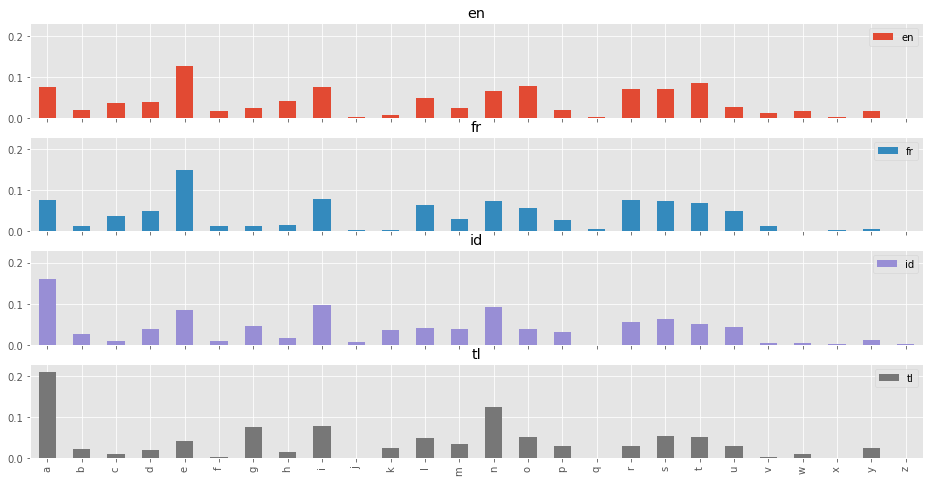

In [47]:
# EDA(시각화 분석)
# 바차트
plt.style.use('ggplot')
df_tmp_pv.plot( kind='bar', subplots=True, figsize=(16,8), ylim=(0, 0.23) )
plt.savefig('./data/plot_bar_langPerFrequences.png')

In [48]:
df_tmp['label'].unique()

array(['en', 'fr', 'id', 'tl'], dtype=object)

In [49]:
df_tmp['label'] == 'en'

0      True
1      True
2      True
3      True
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: label, dtype: bool

In [50]:
df_tmp[ df_tmp['label'] == 'en' ]

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en
2,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553,en
3,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,...,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697,en
4,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,en


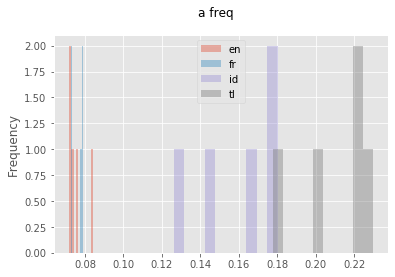

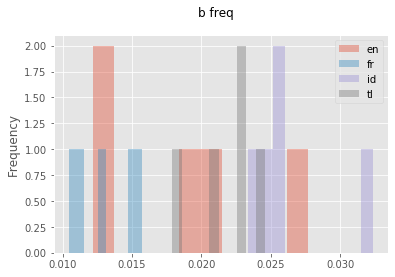

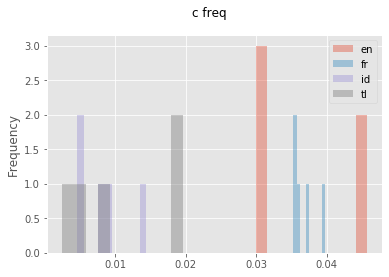

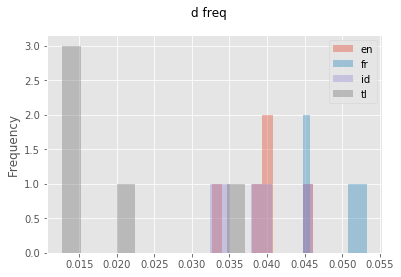

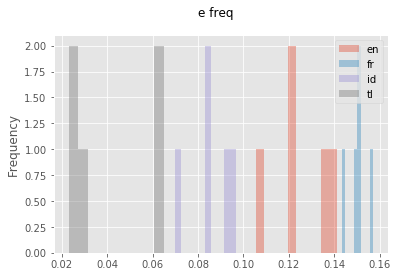

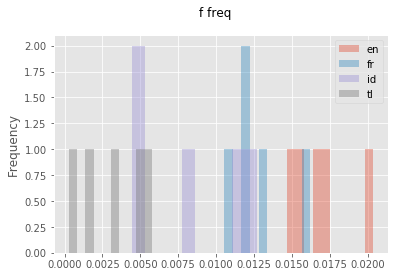

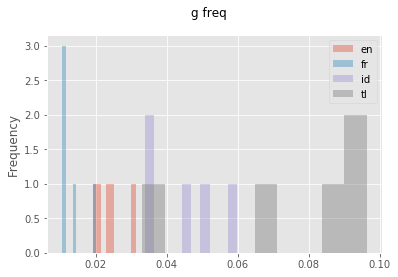

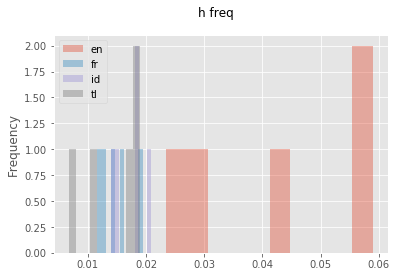

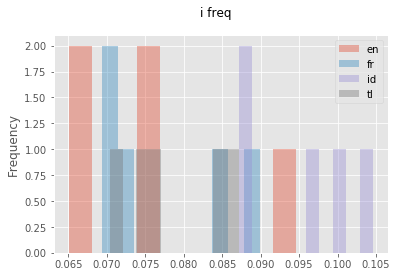

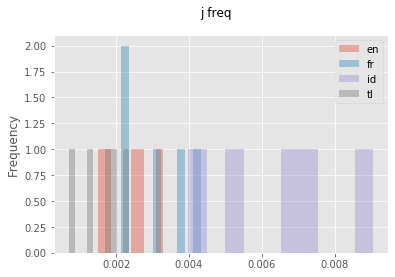

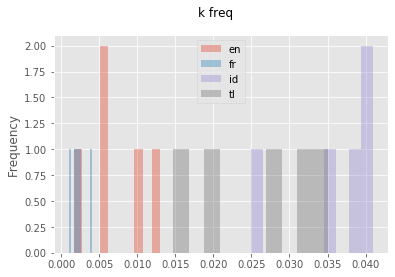

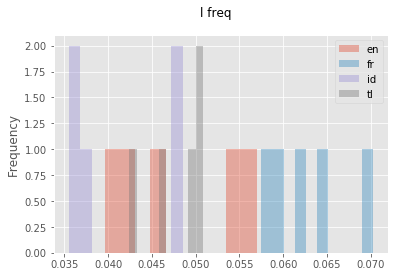

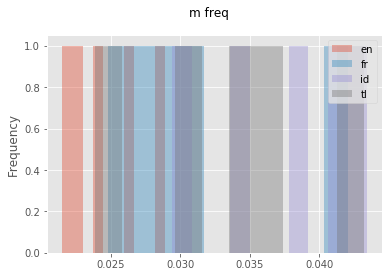

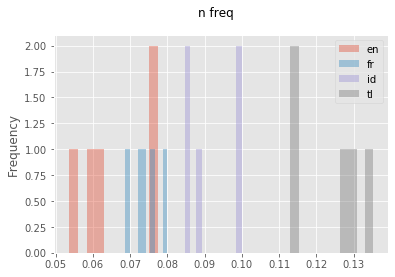

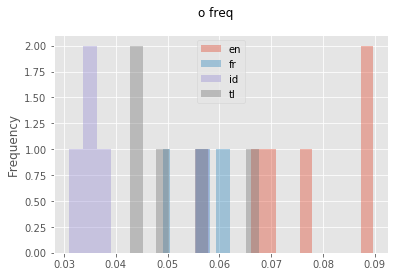

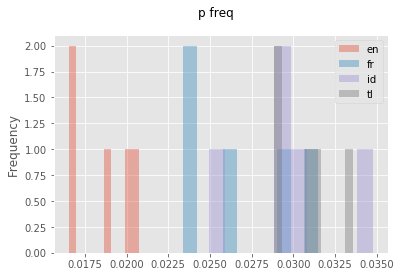

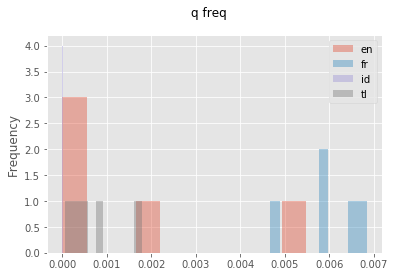

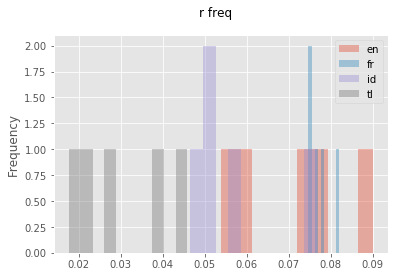

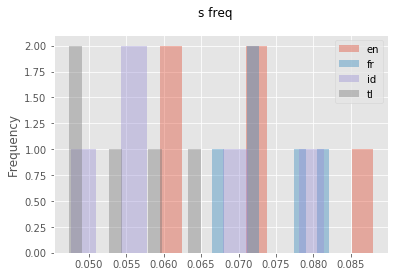

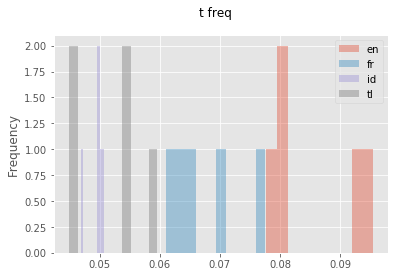

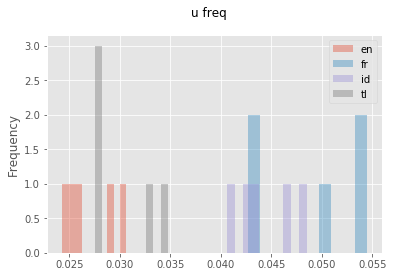

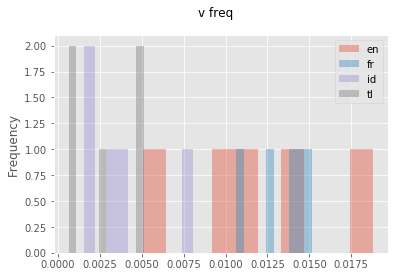

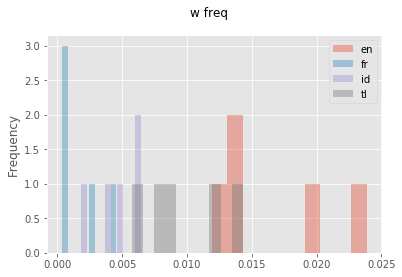

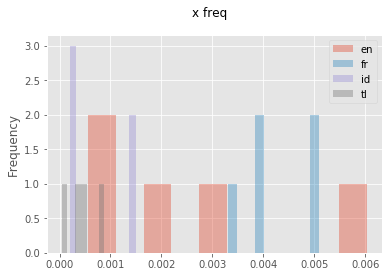

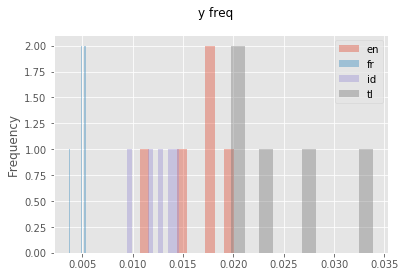

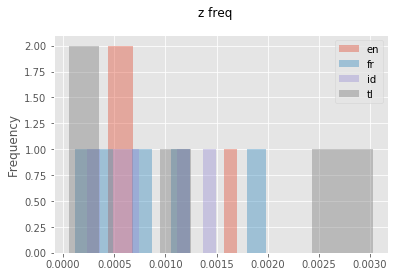

In [65]:
# 히스토그램을 이용하여 알파벳별 국가별 사용 빈도 비교 
# 피벗 데이터가 아닌 원데이터를 이용하여 표시 => df_tmp 사용
nas = df_tmp['label'].unique()
for word in ascii_lowercase:    
    for na in nas:
        # 해당 국가의 데이터만 일단 모은다
        df_tmp_na = df_tmp[ df_tmp['label'] == na ]
        # 영어의 a, 영어의 b, ....타갈리아어의 z
        df_tmp_na[word].plot( kind='hist', alpha=0.4, label=na )
    # 범례
    plt.legend()
    # 제목 : a freq, b freq, .... z freq
    plt.suptitle('%s freq' % word)
    # 저장
    plt.savefig('./data/%s_freq.png' % word)
    # 화면 보이기
    plt.show()
    #break

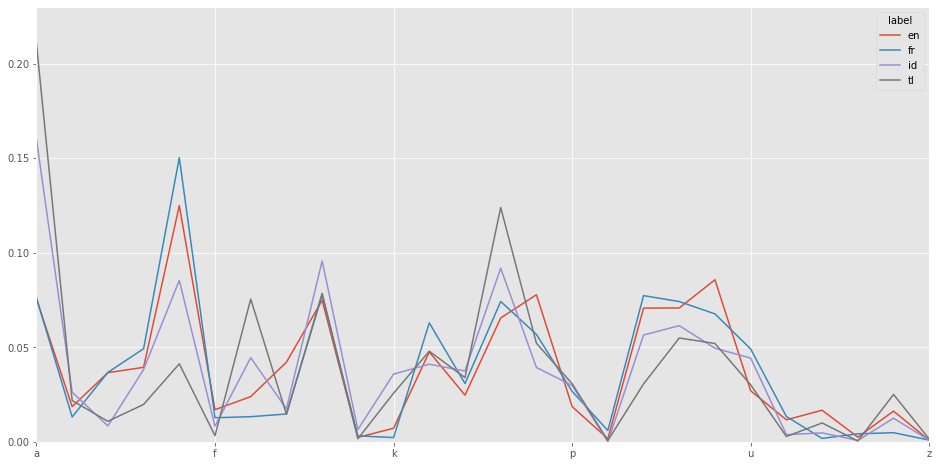

In [52]:
# 선형 그래프를 통해서 확인
df_tmp_pv.plot( kind='line', figsize=(16,8), ylim=(0, 0.23) )
plt.show()

### 5. 데이터 모델링 및 모델 구축

- 알고리즘 선정
- 학습데이터/테스트데이터 준비
- 학습
- 예측
- [생략]성능평가(학습법,하위 카테고리 까지 검토 평가)
- [생략]파이프라인구축을 통하여 알고리즘 체인을 적용, 최적의 알고리즘 조합을 찾는다
- [생략]연구 목표에 도착할때까지 반복

In [53]:
from sklearn import svm, metrics

In [54]:
# 1. 알고리즘 선정
clf = svm.SVC( gamma='auto' )

In [66]:
# 2. 학습데이터/테스트데이터 준비
# 75:25 = 훈련데이터(50:훈련용,25:검증용):테스트데이터 
# train_test_split()
# 이전단계에서 이미 구성이 완료되었다 (생략)
# 훈련 데이터
len(data[0]['labels']), len(data[0]['freqs'])

(20, 20)

In [67]:
# 3. 학습
clf.fit( data[0]['freqs'], data[0]['labels'] )

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
# 4. 예측
# 한번도 만나지 못한 데이터를 가지고 예측 수행
# 훈련(학습)에 사용된 데이터는 사용 불가
predict = clf.predict( data[1]['freqs']  )

In [58]:
predict, len(predict)

(array(['en', 'en', 'fr', 'fr', 'en', 'id', 'tl', 'tl'], dtype='<U2'), 8)

In [59]:
# 5. 결과 확인, 성능확인
# 정확도 87% 이상이면 실제 사용 가능하다고 간주하고(설정) 목표 도달로 간주
score = metrics.accuracy_score( data[1]['labels'], predict )
score

0.875

In [60]:
# 6. 레포트
cl_report = metrics.classification_report( data[1]['labels'], predict )
print( cl_report )
# precision    :  정밀도
# recall       :  재현율
# f1-score     :  점수, 정확도
# support      :  데이터에 응답한 샘플수

              precision    recall  f1-score   support

          en       0.67      1.00      0.80         2
          fr       1.00      1.00      1.00         2
          id       1.00      0.50      0.67         2
          tl       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.92      0.88      0.87         8
weighted avg       0.92      0.88      0.87         8



In [61]:
# 학습시킨 알고리즘을 덤프하여서 6단계 개발자에게 전달
# 사용 메뉴얼, 라이브러리(텍스트 => 빈도계산, 답안 처리하는 데이터 형태로 생성)
from sklearn.externals import joblib

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [62]:
# 저장
joblib.dump( clf, './data/clf_mdoel_202001161419.model' )

['./data/clf_mdoel_202001161419.model']

In [63]:
# 레이블 저장 (이 알고리즘은 지도학습의 분류에 해당되므로, 알고리즘, 답안 데이터)
label_dic = {
    'en':'영어',
    'fr':'프랑스어',
    'tl':'타갈리아어',
    'id':'인도네시아어',
}

In [64]:
# json 덤프 : ./data/clf_labels.label
with open( './data/clf_labels.label', 'w', encoding='utf-8' ) as f:
    json.dump( label_dic, f )

### 6. 시스템 통합

- 웹서비스 구축(falsk 간단하게 구성)
    - IDE : vs code를 사용 
- 서비스 구축
- 모델의 업그레이드를 위한 시스템 추가
- 선순환구조를 위한 번역 요청 데이터의 로그 처리->배치학습, 온라인 학습등으로 연결되어 완성